In [ ]:
#What is Trend?
#The trend component of a time series represents a persistent, long-term change in the mean of the series. 
#The trend is the slowest-moving part of a series, the part representing the largest time scale of importance.
#In a time series of product sales, an increasing trend might be the effect of a market expansion as more people
#become aware of the product year by year.

#https://i.imgur.com/ZdS4ZoJ.png

In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/delhiclimate/DailyDelhiClimateTrain.csv
/kaggle/input/delhiclimate/DailyDelhiClimateTest.csv


In [120]:
# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
data_dir = Path('../input/delhiclimate')

In [139]:
dtype = {
    'meantemp': 'float32',
    'humidity': 'float32',
    'wind_speed': 'float32',
    'meanpressure': 'float32',
}

climate_data = pd.read_csv(
    data_dir / 'DailyDelhiClimateTrain.csv',
#    index_col='date',
    parse_dates=['date'],
)
#Create a time dummy: Time-step features
#There are two kinds of features unique to time series: time-step features and lag features.
#Time-step features are features we can derive directly from the time index. 
#The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.

climate_data['Date_index'] = np.arange(len(climate_data.index))

#Lag features
#To make a lag feature we shift the observations of the target series so that they appear to have occured later in time.
#Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

climate_data['Lag_1'] = climate_data['meantemp'].shift(1)
climate_data = climate_data.reindex(columns=['date', 'meantemp', 'Date_index', 'humidity', 'wind_speed', 'meanpressure','Lag_1'])
climate_data = climate_data.set_index('date').to_period('D')

#climate_data = climate_data.set_index('date').to_period('D')

In [140]:
display(climate_data)

,meantemp,Date_index,humidity,wind_speed,meanpressure,Lag_1
date,,,,,,
2013-01-01,10.000000,0,84.500000,0.000000,1015.666667,NaN
2013-01-02,7.400000,1,92.000000,2.980000,1017.800000,NaN
2013-01-03,7.166667,2,87.000000,4.633333,1018.666667,NaN
2013-01-04,8.666667,3,71.333333,1.233333,1017.166667,NaN
2013-01-05,6.000000,4,86.833333,3.700000,1016.500000,NaN
...,...,...,...,...,...,...
2016-12-28,17.217391,1457,68.043478,3.547826,1015.565217,17.285714
2016-12-29,15.238095,1458,87.857143,6.000000,1016.904762,15.550000
2016-12-30,14.095238,1459,89.666667,6.266667,1017.904762,17.318182


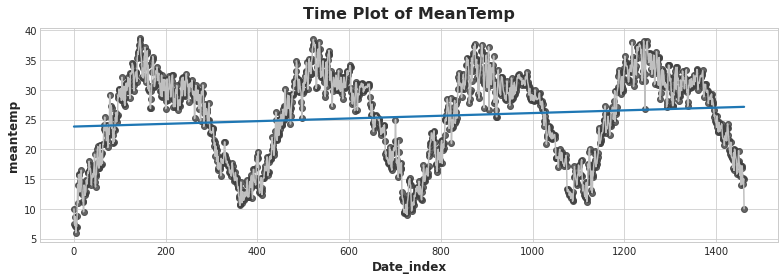

In [141]:
#One advantage linear regression has over more complicated algorithms is that the models it creates are explainable 
#-- it's easy to interpret what contribution each feature makes to the predictions. In the model target = weight * feature + bias, 
#the weight tells you by how much the target changes on average for each unit of change in the feature.

#Here is the linear regression on MeanTemp:

fig, ax = plt.subplots()
ax.plot('Date_index', 'meantemp', data=climate_data, color='0.75')
ax = sns.regplot(x='Date_index', y='meantemp', data=climate_data, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of MeanTemp');

In [142]:
#Prediction with LinearRegression

from sklearn.linear_model import LinearRegression

# reate training data
X = climate_data.loc[:, ['Date_index']] # features
y = climate_data.loc[:, 'meantemp']  # target

# Еrain the model
model = LinearRegression()
model.fit(X, y)

#Store the fitted values as a time series with the same time index as
#the training data
y_pred = pd.Series(model.predict(X), index=X.index)

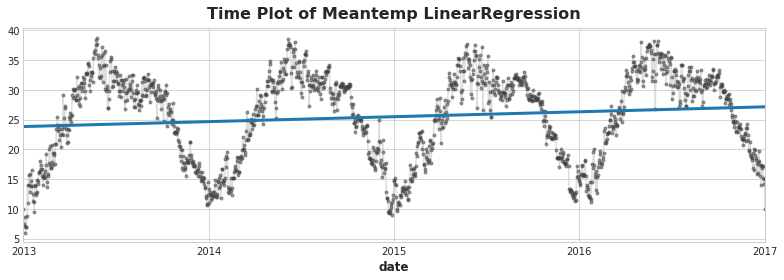

In [143]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Meantemp LinearRegression');

In [144]:
#Fit a lag feature to Meantemp

X = climate_data.loc[:, ['Lag_1']].dropna()  # features
y = climate_data.loc[:, 'meantemp']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target to avoid an error: 
#"ValueError: Found input variables with inconsistent numbers of samples: [1461, 1462]"

#Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X, y)

#Create Store the fitted values as a time series with the same time index as the training data
y_pred_lag = pd.Series(model.predict(X), index=X.index)

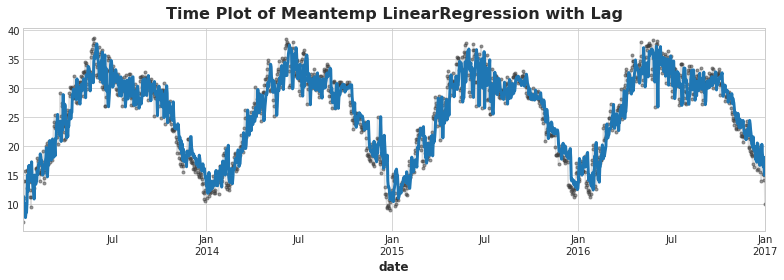

In [145]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred_lag.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Meantemp LinearRegression with Lag');

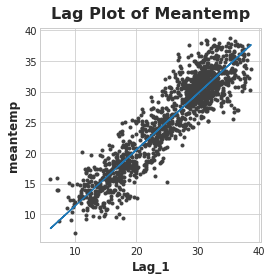

In [146]:
#The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred_lag)
ax.set(aspect='equal', ylabel='meantemp', xlabel='Lag_1', title='Lag Plot of Meantemp');

In [147]:
from sklearn.metrics import mean_absolute_error
#MAE for lags
print(mean_absolute_error(y, y_pred_lag))

#MAE for Linearregression (not good result)
y1 = climate_data.loc[:, 'meantemp'] #to use previous 'y' without droping corresponding values
print(mean_absolute_error(y1, y_pred))

2.1783326545235595
6.314343180336529


In [ ]:
#try another shift for LAG

In [148]:
#Create a Trend Feature
#Use DeterministicProcess to create a feature set for a cubic trend model. Also create features for a 90-day forecast.
#We'll use a function from the statsmodels library called DeterministicProcess. Using this function will help us avoid some tricky
#failure cases that can arise with time series and linear regression. The order argument refers to polynomial order: 1 for linear, 2 for quadratic,
#3 for cubic, and so on.

from statsmodels.tsa.deterministic import DeterministicProcess

#from statsmodels.tsa.deterministic import CalendarFourier
fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

#Instantiate `DeterministicProcess` with arguments appropriate for a cubic trend model
dp = DeterministicProcess(
    index=X.index,  # dates from the training data
    constant=False,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend). Order ==1 for CalendarFourier
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,           # drop terms if necessary to avoid collinearity
)

#Create the feature set for the dates given in y.index
X = dp.in_sample()

#Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

#Try other number of steps and order (4)!

In [234]:
#Requset from series:
print(y_fore.items)
print(y_fore[88])
print(y_fore['2017-03-31'])

<bound method Series.items of 2017-01-02    15.178507
2017-01-03    15.280728
2017-01-04    15.465568
2017-01-05    15.455276
2017-01-06    15.482756
                ...    
2017-03-28    28.754399
2017-03-29    29.097819
2017-03-30    29.234505
2017-03-31    29.399661
2017-04-01    29.525002
Freq: D, Length: 90, dtype: float64>
29.399661341264366
29.399661341264366


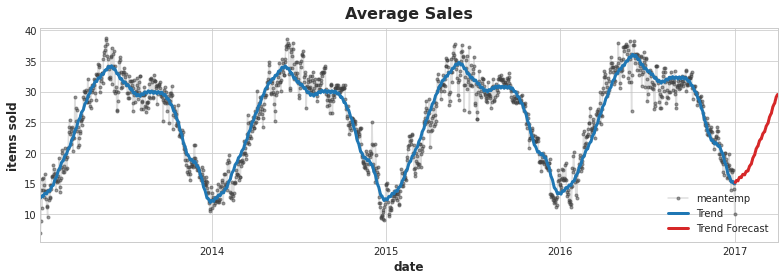

In [149]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In [116]:
print(mean_absolute_error(y, y_pred))

6.30430637046227


In [ ]:
#Linear methods can not be used in periodic (seasonality) tasks
#Fourier features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest.
#Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

#Next is how too choose fourier features.